# Deep dream 

Visualization technique that does this 


[![Supermarket Trip](resources/supermarket_trip.png)](https://www.youtube.com/watch?v=DgPaCWJL7XI "Supermarket Trip")

## Wait but how?

1. Maths,maths and some more maths 
2. Serendipity: Good accidents do happen 
3. Visualization of regular classification networks

## Recipy for a dream

1. Train your network on a classification problem
2. Choose Neuron that you want to be activated more in your new "halucinated" image
3. Change your image to maximize activation on that neuron
4. Repeat 3. till you are happy

### Train your network on a classifcation problem

#### ImageNet

#### Convolutional neural network architecture

[![cnn architecture](resources/cnn.png)](http://www.cognitivetoday.com/2016/10/deep-learning-neural-networks-simplified.html)

*http://www.cognitivetoday.com/2016/10/deep-learning-neural-networks-simplified.html*

When image goes in it activates certain neurons creating image signature

![cnn architecture](resources/image_signature.png)


Filters low layers

![cnn filters layer 1](resources/layers.jpeg)

Filters high layers

![cnn filters high](resources/visualization2.png)


We use pretrained VGG16 network (top5 accuracy 90%)

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input,decode_predictions
from keras.preprocessing import image as img_utils
from keras.layers import Input

# this will contain our generated image
img_size = (224, 224, 3)
input_template = Input(batch_shape=(1,) + img_size)

img_recognition_network = VGG16(input_tensor=input_template, 
                                weights='imagenet', 
                                include_top=True)

Using TensorFlow backend.


In [2]:
img_recognition_network.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (1, 224, 224, 3)      0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (1, 224, 224, 64)     1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (1, 224, 224, 64)     36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (1, 112, 112, 64)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys,os,glob
import numpy as np
sys.path.append('/home/jakub.czakon/deep_learning_art_webinar')
import utils

Some random images from the internet

In [3]:
img_filename_list = utils.get_images_from_directory(dir_path='data',
                                                    extensions = ['jpg','jpeg'])

img_list = [img_utils.load_img(f,target_size= img_size[:2]) 
            for f in img_filename_list]
img_tensors_list = [utils.img2vggtensor(im) for im in img_list]

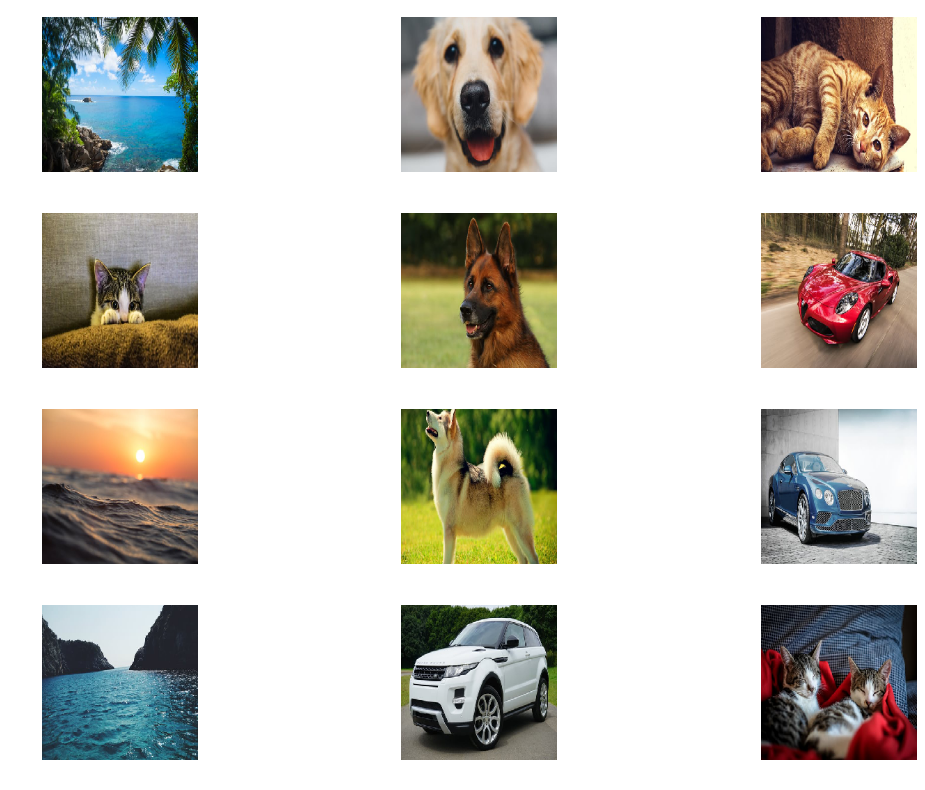

In [5]:
utils.plot_list(img_list)

Lets get predictions from our VGG net

In [6]:
predictions = [img_recognition_network.predict(im) for im in img_tensors_list]

In [7]:
labels = [decode_predictions(p)[0][1] for p in predictions]

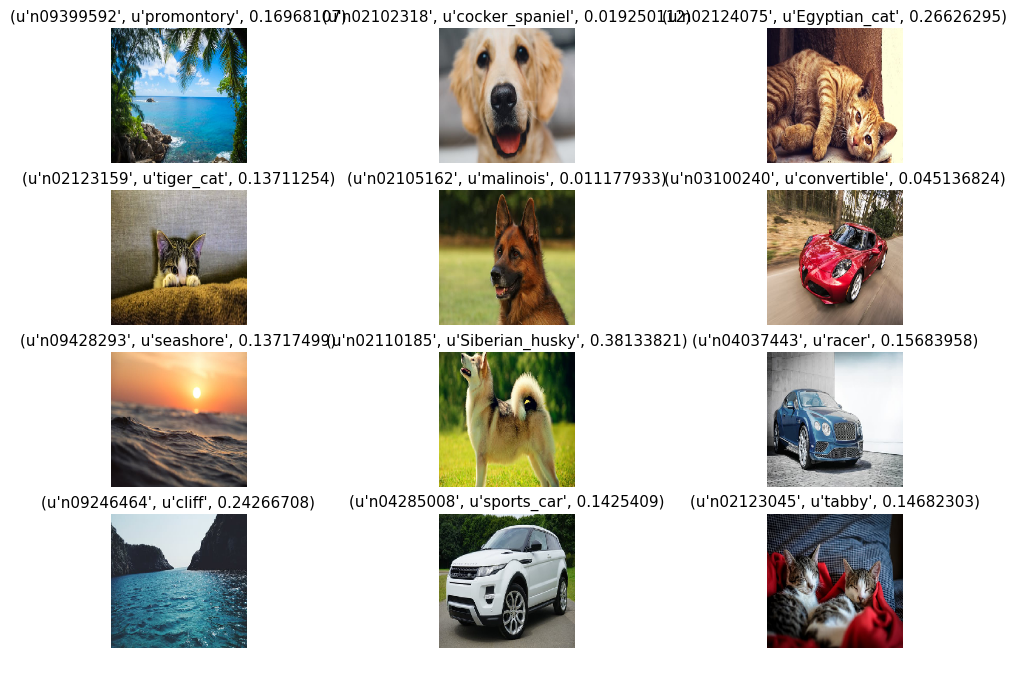

In [8]:
utils.plot_list(img_list=img_list,labels=labels)

### Lets visualize activated neurons for a given image

In [9]:
img_raw = img_list[3]
img_prep = utils.img2vggtensor(img_raw)

In [4]:
from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], 
                                 [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations[0]

def get_filters(model, layer):
    return model.layers[layer].get_weights()[0]

In [11]:
for i in range(20):
    try:
        result  = get_filters(img_recognition_network,i)
        print i,result.shape
    except Exception:
        pass

1 (3, 3, 3, 64)
2 (3, 3, 64, 64)
4 (3, 3, 64, 128)
5 (3, 3, 128, 128)
7 (3, 3, 128, 256)
8 (3, 3, 256, 256)
9 (3, 3, 256, 256)
11 (3, 3, 256, 512)
12 (3, 3, 512, 512)
13 (3, 3, 512, 512)
15 (3, 3, 512, 512)
16 (3, 3, 512, 512)
17 (3, 3, 512, 512)


(3, 3, 512, 512)
layer name:block5_conv2
neuron number


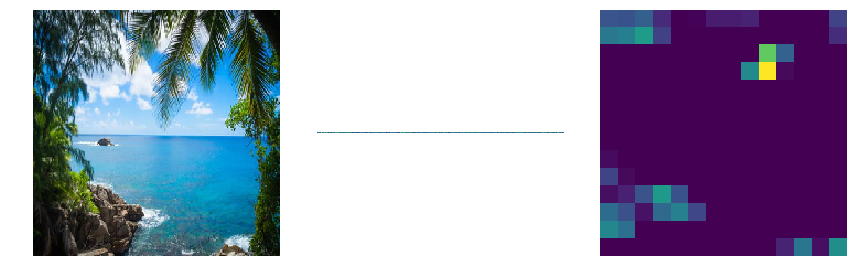

<function __main__.plot_model_output>

In [23]:
from ipywidgets import interact
def plot_model_output(img_nr,layer_nr,filter_nr):
    img_nr, layer_nr,filter_nr = [int(x) for x in [img_nr,layer_nr,filter_nr]]
    
    img_raw = img_list[img_nr]
    img_prep = utils.img2vggtensor(img_raw)    

    result = get_activations(img_recognition_network,layer_nr,img_prep)
    output = result[0,:,:,filter_nr]
    
    neurons = get_filters(img_recognition_network,layer_nr)
    print neurons.shape
    neuron = neurons[0,:,:,filter_nr]
    
    print "layer name:{}\nneuron number".\
    format(img_recognition_network.layers[layer_nr].name,filter_nr)
    utils.plot_list([img_raw,neuron,output],cols_nr=3)
    
interact(plot_model_output,img_nr='0',layer_nr = '16',filter_nr='2')

In [15]:
img_recognition_network.layers[17].output_shape

(1, 14, 14, 512)

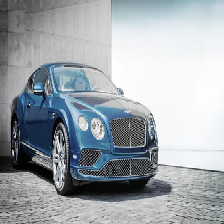

In [15]:
img_list[8]

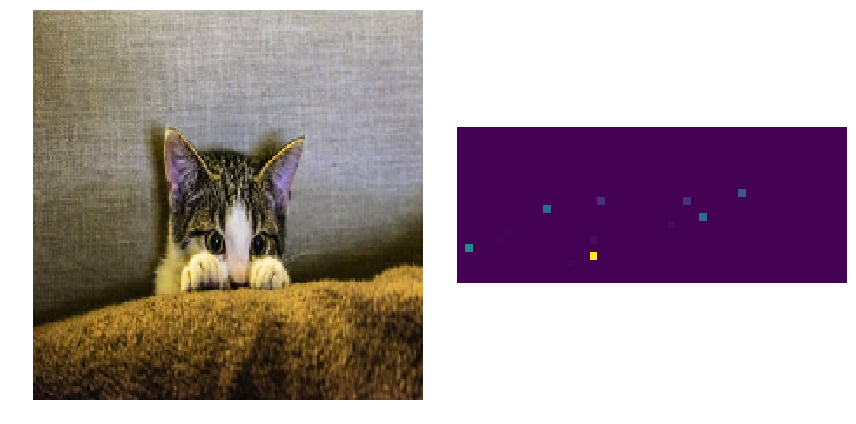

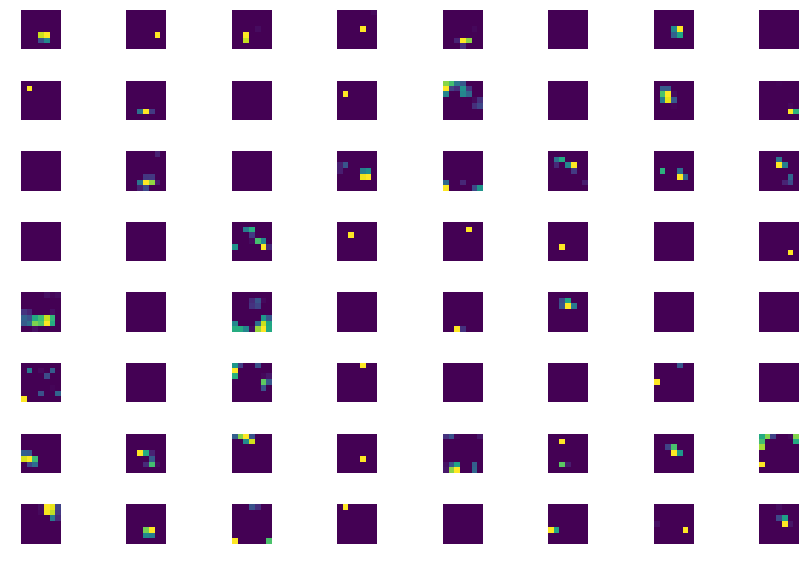

In [12]:
def plot_last_layer(img_nr):
    img_nr = int(img_nr)
    
    img_prep = utils.img2vggtensor(img_list[img_nr])    
        
    layer_nr = 18
    
    output_last = get_activations(img_recognition_network,22,img_prep).reshape(20,50)
    outputs_for_layer = get_activations(img_recognition_network,layer_nr,img_prep)

    output_list = [outputs_for_layer[0,:,:,f_nr] for f_nr in range(64)]    
    
    utils.plot_list([img_raw,output_last],cols_nr=2)
    utils.plot_list(output_list)  

interact(plot_last_layer,img_nr='0')

## Lets Dream 

In [5]:
layer_nr = 12
filter_nr = 8
coeff = 0.01
jitter = 15

layer_dict = utils.get_layer_dict(img_recognition_network)

In [6]:
x = layer_dict[layer_nr].output[:,:,:,filter_nr]
shape = layer_dict[layer_nr].output_shape[:3]

loss =  - coeff * K.sum(K.square(x))

grads = K.gradients(loss, input_template)


f_outputs = K.function([input_template], [loss] + grads)

In [7]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt


img_dream = img_utils.load_img("resources/shop.jpeg",target_size = img_size[:2])
tens = utils.img2vggtensor(img_dream) 

evaluator = Evaluator()

for i in range(100):

    random_jitter = (jitter * 2) * (np.random.random(img_size) - 0.5)

    tens += random_jitter

    tens, min_val, info = fmin_l_bfgs_b(evaluator.loss, tens.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    
    tens = tens.reshape((1,)+img_size)   
    tens -= random_jitter
    
    activations = get_activations(img_recognition_network,layer_nr,tens)
    filter_output = activations[0,:,:,filter_nr]
    
    filter_output /= filter_output.max()
    filter_output *=255.
    filter_output = filter_output.astype(np.uint8)
    
    print filter_output.mean(),filter_output[:2]
    
    img = utils.deprocess_image(np.copy(tens)[0])
    
    plt.imsave(os.path.join("results","shop_{}_{}_{}_{}_{}.jpg".\
                            format(layer_nr,
                                   filter_nr,
                                   coeff,
                                   jitter,
                                   i
                                  )),img)
 
    utils.plot_list([img,filter_output],cols_nr=2)